In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


****Seq2Seq Model for generating the second mesras of ferdosi poems by Using Keras API****

*   **In The First Part I will Implement Seq2Seq Encoder_Decoder model Without Attention**

*   **In The Second Part I will Implement Seq2Seq Encoder_Decoder model With Using Attention Based on "Effective Approaches to Attention-based Neural Machine Translation" Paper ***

   https://arxiv.org/abs/1508.04025) 



# **Sequence to Sequence model Without Attention**

**First Import The necessary Libraries**

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras.layers import LSTM, Input, Dense, Embedding, Activation, dot, concatenate
from keras.losses import categorical_crossentropy
from keras.preprocessing import text
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.np_utils import to_categorical
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.models import Model, load_model

Using TensorFlow backend.


**Now Load The Dataset**

In [0]:
sher = np.loadtxt('/content/drive/My Drive/Colab Notebooks/ferdosi.txt', dtype= 'str', delimiter= ',')

***Let's See one of Dataset Samples ***

In [0]:
sher[0]

array(['به نام خداوند جان و خرد ', ' کزین برتر اندیشه برنگذرد'],
      dtype='<U35')

**Split The Sentences into characters and add 'bom', 'eom' to decoder inputs and outputs**

In [0]:
sher_charac_first = []
sher_charac_second_input = []
sher_charac_second_output = []



for l in range(len(sher)):

    first_mes = list(sher[l][0]) # split the sentences of first mesra to characters
    sher_charac_first.append(first_mes)

    second_mes_in = list(sher[l][1])# split the sentences of second mesra to characters
    second_mes_in.insert(0, 'bom')
    sher_charac_second_input.append(second_mes_in)

    second_mes_out =  list(sher[l][1])# split the sentences of second mesra to characters
    second_mes_out.insert(len(sher[l][1]), 'eom')
    sher_charac_second_output.append(second_mes_out)


**Here is the example of splited Sentences**

In [0]:
sher_charac_first[0], sher_charac_second_input[0]

(['ب',
  'ه',
  ' ',
  'ن',
  'ا',
  'م',
  ' ',
  'خ',
  'د',
  'ا',
  'و',
  'ن',
  'د',
  ' ',
  'ج',
  'ا',
  'ن',
  ' ',
  'و',
  ' ',
  'خ',
  'ر',
  'د',
  ' '],
 ['bom',
  ' ',
  'ک',
  'ز',
  'ی',
  'ن',
  ' ',
  'ب',
  'ر',
  'ت',
  'ر',
  ' ',
  'ا',
  'ن',
  'د',
  'ی',
  'ش',
  'ه',
  ' ',
  'ب',
  'ر',
  'ن',
  'گ',
  'ذ',
  'ر',
  'د'])

**Compute the maximum length of mesras**

In [0]:
first_max = 0
for t in range(len(sher_charac_first)):
    if len(sher_charac_first[t])> first_max:
        first_max = len(sher_charac_first[t])

second_max = 0
for y in range(len(sher_charac_second_input)):
    if len(sher_charac_second_input[y])> second_max:
        second_max = len(sher_charac_second_input[y])

max_total = max(first_max,second_max)

In [0]:
max_total

36

**Add The 'pad' to mesras until their length be equal to max_total**

In [0]:
for u in range(len(sher_charac_first)):
    while len(sher_charac_first[u]) < max_total:
          sher_charac_first[u].insert(0, 'pad')

for v in range(len(sher_charac_second_input)):
    while len(sher_charac_second_input[v]) < max_total:
          sher_charac_second_input[v].insert(len(sher_charac_second_input[v]), 'pad')

for w in range(len(sher_charac_second_output)):
    while len(sher_charac_second_output[w]) < max_total:
          sher_charac_second_output[w].insert(len(sher_charac_second_output[w])-1, 'pad')


**Here is the final mesras after preprocessings**

In [0]:
sher_charac_first[0], sher_charac_second_input[0]

(['pad',
  'pad',
  'pad',
  'pad',
  'pad',
  'pad',
  'pad',
  'pad',
  'pad',
  'pad',
  'pad',
  'pad',
  'ب',
  'ه',
  ' ',
  'ن',
  'ا',
  'م',
  ' ',
  'خ',
  'د',
  'ا',
  'و',
  'ن',
  'د',
  ' ',
  'ج',
  'ا',
  'ن',
  ' ',
  'و',
  ' ',
  'خ',
  'ر',
  'د',
  ' '],
 ['bom',
  ' ',
  'ک',
  'ز',
  'ی',
  'ن',
  ' ',
  'ب',
  'ر',
  'ت',
  'ر',
  ' ',
  'ا',
  'ن',
  'د',
  'ی',
  'ش',
  'ه',
  ' ',
  'ب',
  'ر',
  'ن',
  'گ',
  'ذ',
  'ر',
  'د',
  'pad',
  'pad',
  'pad',
  'pad',
  'pad',
  'pad',
  'pad',
  'pad',
  'pad',
  'pad'])

***Get the unique characters of mesras ***

In [0]:
sher = sher_charac_first + sher_charac_second_input + sher_charac_second_output

combined_list=[]
for x in sher:
    combined_list.extend(x)

characters = list(np.unique(combined_list))
vocab_size = len(characters)

**After That, vocab_size is the number of unique characters**

In [0]:
(vocab_size)

40

**Characters is the list of all unique characters of mesras**

In [0]:
characters

[' ',
 'bom',
 'eom',
 'pad',
 'ء',
 'أ',
 'ؤ',
 'ئ',
 'ا',
 'ب',
 'ت',
 'ث',
 'ج',
 'ح',
 'خ',
 'د',
 'ذ',
 'ر',
 'ز',
 'س',
 'ش',
 'ص',
 'ض',
 'ط',
 'ظ',
 'ع',
 'غ',
 'ف',
 'ق',
 'ل',
 'م',
 'ن',
 'ه',
 'و',
 'پ',
 'چ',
 'ژ',
 'ک',
 'گ',
 'ی']

**Create The word to index and index to word dictionary**

In [0]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(characters)

word2id = tokenizer.word_index
id2word = tokenizer.index_word

**Let's see the word to index dictionary**

In [0]:
word2id

{'bom': 1,
 'eom': 2,
 'pad': 3,
 'ء': 4,
 'أ': 5,
 'ؤ': 6,
 'ئ': 7,
 'ا': 8,
 'ب': 9,
 'ت': 10,
 'ث': 11,
 'ج': 12,
 'ح': 13,
 'خ': 14,
 'د': 15,
 'ذ': 16,
 'ر': 17,
 'ز': 18,
 'س': 19,
 'ش': 20,
 'ص': 21,
 'ض': 22,
 'ط': 23,
 'ظ': 24,
 'ع': 25,
 'غ': 26,
 'ف': 27,
 'ق': 28,
 'ل': 29,
 'م': 30,
 'ن': 31,
 'ه': 32,
 'و': 33,
 'پ': 34,
 'چ': 35,
 'ژ': 36,
 'ک': 37,
 'گ': 38,
 'ی': 39}

**Adding the space character to word to index and index to word dictionaries**

In [0]:
word2id[' '] = 0
id2word[0] = ' '

**See word to index and index to word after adding space character**

In [0]:
word2id

{' ': 0,
 'bom': 1,
 'eom': 2,
 'pad': 3,
 'ء': 4,
 'أ': 5,
 'ؤ': 6,
 'ئ': 7,
 'ا': 8,
 'ب': 9,
 'ت': 10,
 'ث': 11,
 'ج': 12,
 'ح': 13,
 'خ': 14,
 'د': 15,
 'ذ': 16,
 'ر': 17,
 'ز': 18,
 'س': 19,
 'ش': 20,
 'ص': 21,
 'ض': 22,
 'ط': 23,
 'ظ': 24,
 'ع': 25,
 'غ': 26,
 'ف': 27,
 'ق': 28,
 'ل': 29,
 'م': 30,
 'ن': 31,
 'ه': 32,
 'و': 33,
 'پ': 34,
 'چ': 35,
 'ژ': 36,
 'ک': 37,
 'گ': 38,
 'ی': 39}

In [0]:
id2word

{0: ' ',
 1: 'bom',
 2: 'eom',
 3: 'pad',
 4: 'ء',
 5: 'أ',
 6: 'ؤ',
 7: 'ئ',
 8: 'ا',
 9: 'ب',
 10: 'ت',
 11: 'ث',
 12: 'ج',
 13: 'ح',
 14: 'خ',
 15: 'د',
 16: 'ذ',
 17: 'ر',
 18: 'ز',
 19: 'س',
 20: 'ش',
 21: 'ص',
 22: 'ض',
 23: 'ط',
 24: 'ظ',
 25: 'ع',
 26: 'غ',
 27: 'ف',
 28: 'ق',
 29: 'ل',
 30: 'م',
 31: 'ن',
 32: 'ه',
 33: 'و',
 34: 'پ',
 35: 'چ',
 36: 'ژ',
 37: 'ک',
 38: 'گ',
 39: 'ی'}

**check the shape of preprocessed mesras**

In [0]:
np.shape(sher_charac_first)

(49609, 36)

**Substitute the characters with  their index of word to index dictionary**

In [0]:
sher_number_first = [[ word2id[w] for w in doc ] for doc in sher_charac_first]
sher_number_second_input = [[ word2id[w] for w in doc ] for doc in sher_charac_second_input]
sher_number_second_output = [[ list(to_categorical(word2id[w], vocab_size, dtype = int)) for w in doc ] for doc in sher_charac_second_output]

**See the changes and check their shapes**

In [0]:
sher_number_first[0][1:10], np.shape(sher_number_first), np.shape(sher_number_second_output)

([3, 3, 3, 3, 3, 3, 3, 3, 3], (49609, 36), (49609, 36, 40))

**Split the whole data to train and test parts**

In [0]:
encoder_input_train,  encoder_input_test, decoder_input_train,decoder_input_test,outputs_train, outputs_test = train_test_split(sher_number_first,
                                                                                                               sher_number_second_input, sher_number_second_output
                                                                                                               , test_size= 0.1, shuffle= True )

**Create the Network**

In [0]:
latent_dim = 150
encoder_inputs = Input(shape= (None,))
encoder_embedding = Embedding(input_dim= vocab_size, output_dim= 30)
encoder_embedding_output = encoder_embedding(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state= True, dropout= 0.3,  name= 'encoder_LSTM')
encoder_output, state_h, state_c = encoder_lstm(encoder_embedding_output)
encoder_states = [state_h, state_c]


decoder_inputs = Input(shape= (None, ))
decoder_embedding = Embedding(input_dim= vocab_size, output_dim= 30)
decoder_embedding_output = decoder_embedding(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_state= True, return_sequences= True, dropout= 0.3, name= 'decoder_LSTM')
decoder_outputs, decoder_state_h,  decoder_state_c = decoder_lstm(decoder_embedding_output, initial_state = encoder_states)
decoder_dense = Dense(vocab_size, activation= 'softmax')
output = decoder_dense(decoder_outputs)
model= keras.Model([encoder_inputs, decoder_inputs], output)
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 30)     1200        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 30)     1200        input_2

**Let's Visualize the Network architecture to better understand**

**In the first part we define the encoder and use it's last hidden state as initial hidden state in decoder**

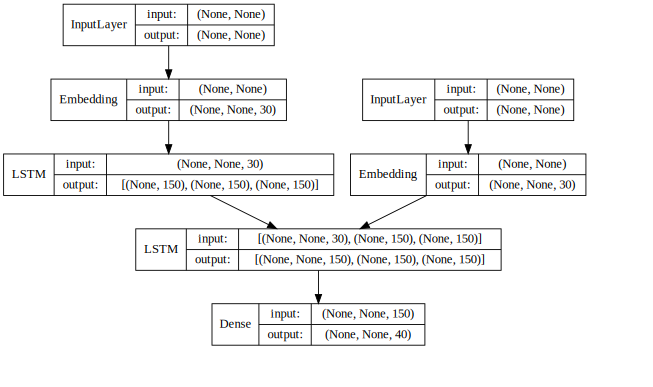

In [0]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi= 65).create(prog='dot', format='svg'))

**Compile the model and prepare the colab Tensorboard**

In [0]:
model.compile(optimizer= 'adam', loss= categorical_crossentropy)
tbc=TensorBoardColab()



Wait for 8 seconds...
TensorBoard link:
https://0a4cb022.ngrok.io


**Train the model with batch_size = 32 and number_of_epochs = 20**

In [0]:
model.fit(x= [np.array(encoder_input_train), np.array(decoder_input_train)], y= np.array(outputs_train),
          batch_size= 32, epochs= 20, callbacks= [TensorBoardColabCallback(tbc)], shuffle= True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










Epoch 1/20
44648/44648 [==============================] - 124s 3ms/step - loss: 1.6940

Epoch 2/20
44648/44648 [==============================] - 129s 3ms/step - loss: 1.4288
Epoch 3/20
44648/44648 [==============================] - 127s 3ms/step - loss: 1.3185
Epoch 4/20
44648/44648 [==============================] - 130s 3ms/step - loss: 1.2475
Epoch 5/20
44648/44648 [==============================] - 127s 3ms/step - loss: 1.2035
Epoch 6/20
44648/44648 [==============================] - 129s 3ms/step - loss: 1.1811
Epoch 7/20
44648/44648 [==============================] - 128s 3ms/step - loss: 1.1546
Epoch 8/20
44648/44648 [==============================] - 129s 3ms/step - loss: 1.1357
Epoch 9/20
44648/44648 [==============================] - 131s 3ms/step - loss: 1.1230
Epoch 10/20
44648/44648 [==============================] - 130s 3ms/step - loss: 1.1064
Epoch 11/20
44648/44648 

**See the loss during the time in training**

****

![alt text](https://drive.google.com/uc?id=12eYX5Py86V2aIzmyMTkWaEGFlGje4v5g)

**After Training save the model and when necessary load the trained model**

In [0]:
# model.save('/content/drive/My Drive/Colab Notebooks/model.h5')
# model = load_model('/content/drive/My Drive/Colab Notebooks/model.h5')

**Compute the loss in test part of dataset**

In [0]:
model.evaluate(x= [np.array(encoder_input_test), np.array(decoder_input_test)], y= np.array(outputs_test))

4961/4961 [==============================] - 3s 640us/step


0.9951975852148929

So the loss of model in test data is 0.99 and is lower than loss in tarin data.
it's great and shows my model has't been overfitted.

**Now it's the time for creating inference model**

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)

In [0]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_input_single = Input(shape= (1,))
decoder_embedding_single = decoder_embedding(decoder_input_single)
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding_single, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_input_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

*** See the graphical view of inference model ***

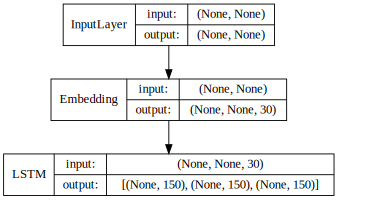

In [0]:
SVG(model_to_dot(encoder_model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi= 65).create(prog='dot', format='svg'))

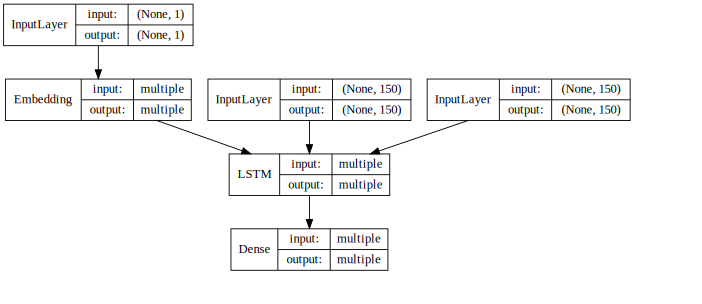

In [0]:
SVG(model_to_dot(decoder_model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi= 65).create(prog='dot', format='svg'))


**In the below cell we loaded the poems again because after preprocessing the loaded dataset has been changed.**

In [0]:
sher_for_inference = np.loadtxt('/content/drive/My Drive/Colab Notebooks/ferdosi.txt', dtype= 'str', delimiter= ',')

**Define the mesra generation function given the first mesra**


In [0]:
def decode_sequence(input_first_mes):

    first_mes = list(input_first_mes) # split the sentences of first mesra to characters
    while len(first_mes) < max_total:
          first_mes.insert(0, 'pad')#add 'pad'to the input first mesra
    first_mes_number = [word2id[w] for w in first_mes]
    first_mes_number = np.reshape(first_mes_number, [1, -1])

    # Encode the input as state vectors
    states_value = encoder_model.predict(first_mes_number)

    # Populate the first character of target sequence with the start character
    target_seq = word2id['bom']
    target_seq = np.reshape(target_seq,[1, 1])  

    stop_condition = False
    decoded_sentence = []

    while not stop_condition:

        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token that has maximum probability
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        sampled_char = id2word[sampled_token_index]
        decoded_sentence.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 'eom' or
           len(decoded_sentence) > max_total):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = sampled_token_index
        target_seq = np.reshape(target_seq,[1, 1]) 

        # Update states
        states_value = [h, c]

    return decoded_sentence

**Give the 10 first mesra of ferdosi poems and generate the second mesras**

In [0]:
sequences_generated = []
sequences_true = []


for i in range(10):
  gen_seq = decode_sequence(sher_for_inference[i+300][0])
  gen_seq_refi = [x for x in gen_seq if x != 'eom' and x != 'pad']
  gen_seq_refi =''.join(gen_seq_refi)
  sequences_generated.append(gen_seq_refi)
  sequences_true.append(sher_for_inference[i+300][0])

  

**The Generated and True Mesras**

In [0]:
sequences_generated

[' به دینار و با او به کار سپاه',
 ' به دینار و با او به ایران سپهر',
 ' به دینار با او بران باد و درد',
 ' به دینار با او بران باد و بند',
 ' به دینار با او بران بار و بوم',
 ' به دینار و با او به ایران سپهر',
 ' به دینار و با او به ایران سپاه',
 ' به دینار با او بران بار و کوه',
 ' به دینار با او بران باد و بند',
 ' به دینار با او برامد بسست']

In [0]:
sequences_true

['که بر هفت کشور منم پادشا ',
 'به فرمان یزدان پیروزگر ',
 'وزان پس جهان یکسر اباد کرد ',
 'نخستین یکی گوهر امد به چنگ ',
 'سر مایه کرد اهن ابگون ',
 'یکی روز شاه جهان سوی کوه ',
 'پدید امد از دور چیزی دراز ',
 'دوچشم از بر سر چو دو چشمه خون ',
 'نگه کرد هوشنگ باهوش و سنگ ',
 'به زور کیانی رهانید دست ']

**I also put the picture of generated and true mesras below for the sake of caution**

![alt text](https://drive.google.com/uc?id=1YfuZO0z0LiQqsTafse9o3iSiei1HRzme)

# **Sequence to Sequence Model with Attention**

**Now Let's try the attention based network. In the below cell the attention mechanism based on  "Effective Approaches to Attention-based Neural Machine Translation" paper is implemented ***

In [0]:
latent_dim = 150


encoder_inputs = Input(shape= (None, ))
encoder_embedding = Embedding(input_dim= vocab_size, output_dim= 20)
encoder_embedding_output = encoder_embedding(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state= True,return_sequences= True, dropout= 0.3,  name= 'encoder_LSTM')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding_output)
encoder_states = [state_h, state_c]


decoder_inputs = Input(shape= (None, ))
decoder_embedding = Embedding(input_dim= vocab_size, output_dim= 20)
decoder_embedding_output = decoder_embedding(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_state= True, return_sequences= True, dropout= 0.3, name= 'decoder_LSTM')
decoder_outputs, decoder_state_h,  decoder_state_c = decoder_lstm(decoder_embedding_output, initial_state = encoder_states)

attention = dot([decoder_outputs,encoder_outputs], axes= [2,2])
attention_output = Activation('softmax')(attention)
context = dot([attention_output, encoder_outputs], axes= [2,1])
decoder_combined_context = concatenate([context, decoder_outputs])
decoder_dense_context = Dense(64, activation= 'tanh')
decoder_dense = decoder_dense_context(decoder_combined_context)

decoder_dense_output = Dense(vocab_size, activation= 'softmax')
output = decoder_dense_output(decoder_dense)
model_attention = keras.Model([encoder_inputs, decoder_inputs], output)
model_attention.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 20)     800         input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 20)     800         input_4[0][0]                    
____________________________________________________________________________________________

**Let's Visualize the Attention Network architecture to better understand**

***In the first part we define the encoder and use it's last hidden state as initial hidden state in decoder and also compute context tensor based on all encoder_outputs and alignment model. Finally we Concatenate the context tensor and decoder outputs  as input to fully connected with "softmax" activation and vocabulary size dimension ***

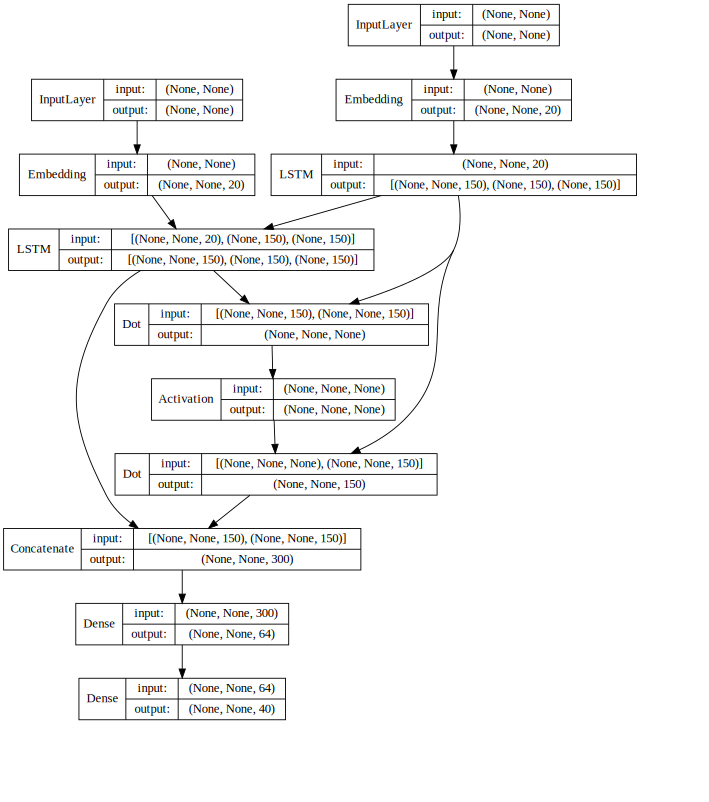

In [0]:
SVG(model_to_dot(model_attention, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi= 65).create(prog='dot', format='svg'))

**Compile the attention model and prepare the colab Tensorboard**

In [0]:
model_attention.compile(optimizer= 'adam', loss= categorical_crossentropy)
tbc=TensorBoardColab()



Wait for 8 seconds...
TensorBoard link:
https://3334020f.ngrok.io


**Train the attention model with batch_size = 32 and number_of_epochs = 20**

In [0]:
model_attention.fit(x= [np.array(encoder_input_train), np.array(decoder_input_train)], y= np.array(outputs_train),
          batch_size= 32, epochs= 20, callbacks= [TensorBoardColabCallback(tbc)], shuffle= True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










Epoch 1/20
44648/44648 [==============================] - 127s 3ms/step - loss: 1.7934

Epoch 2/20
44648/44648 [==============================] - 128s 3ms/step - loss: 1.5489
Epoch 3/20
44648/44648 [==============================] - 129s 3ms/step - loss: 1.4045
Epoch 4/20
44648/44648 [==============================] - 127s 3ms/step - loss: 1.3167
Epoch 5/20
44648/44648 [==============================] - 130s 3ms/step - loss: 1.2610
Epoch 6/20
44648/44648 [==============================] - 128s 3ms/step - loss: 1.2062
Epoch 7/20
44648/44648 [==============================] - 128s 3ms/step - loss: 1.1647
Epoch 8/20
44648/44648 [==============================] - 128s 3ms/step - loss: 1.1300
Epoch 9/20
44648/44648 [==============================] - 127s 3ms/step - loss: 1.0968
Epoch 10/20
44648/44648 [==============================] - 128s 3ms/step - loss: 1.0736
Epoch 11/20
44648/44648 

**See the loss during the time in training**

![alt text](https://drive.google.com/uc?id=1i0x9I3EPW-A1sP4JNnkuY_vjBRmzBmA6)

We See that the loss of attention model is lower that model without attention

**After Training save the attention model and when necessary load the trained attention model**

In [0]:
# model_attention.save('/content/drive/My Drive/Colab Notebooks/model_attention.h5')
# model_attention = load_model('/content/drive/My Drive/Colab Notebooks/model_attention.h5')

**get the attention model loss in test part of dataset**

In [0]:
model_attention.evaluate(x= [np.array(encoder_input_test), np.array(decoder_input_test)], y= np.array(outputs_test))

4961/4961 [==============================] - 3s 701us/step


0.9416581473747488

**So the loss of attention model in test data is 0.94 and is lower than loss in tarin data.** 
**it's great and shows my attention model has't been overfitted.**

**Now it's the time for creating inference model**

In [0]:
encoder_model_attention = Model(encoder_inputs, [encoder_outputs] + encoder_states)

In [0]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
encoder_outputs_inference = Input(shape= (None,latent_dim,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_input_single = Input(shape= (1,))
decoder_embedding_single = decoder_embedding(decoder_input_single)
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding_single, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

attention_inference = dot([decoder_outputs,encoder_outputs_inference], axes= [2,2])
attention_output_inference = Activation('softmax')(attention_inference)
context_inference = dot([attention_output_inference, encoder_outputs_inference], axes= [2,1])
decoder_combined_context_inference = concatenate([context_inference, decoder_outputs])
decoder_outputs_context = decoder_dense_context(decoder_combined_context_inference)
decoder_outputs_fianl = decoder_dense_output(decoder_outputs_context)

decoder_model_attention = Model([decoder_input_single] + [encoder_outputs_inference] + decoder_states_inputs , [decoder_outputs_fianl] + decoder_states)

***See the graphical view of encoder and decoder part of inference attention model  ***

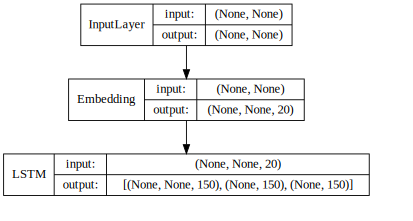

In [0]:
SVG(model_to_dot(encoder_model_attention, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi= 65).create(prog='dot', format='svg'))

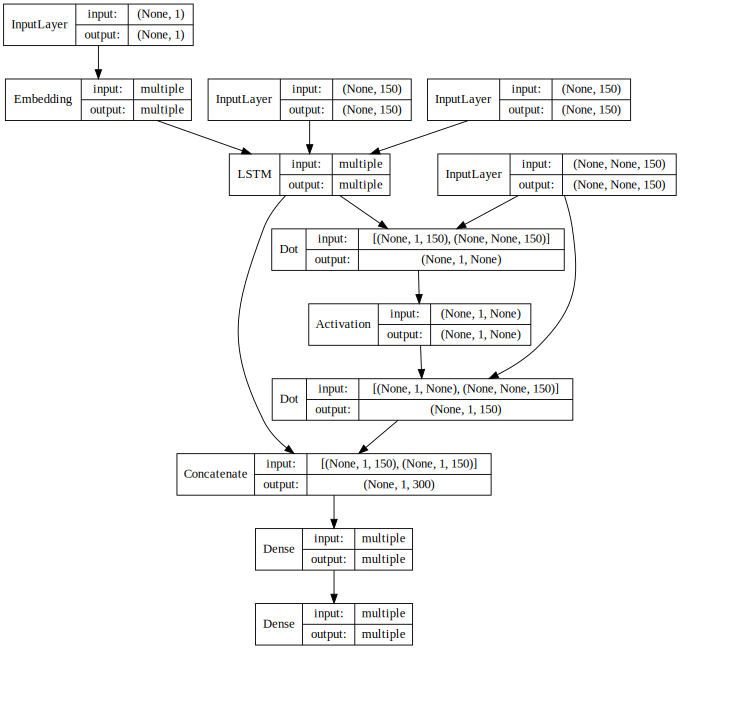

In [0]:
SVG(model_to_dot(decoder_model_attention, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi= 65).create(prog='dot', format='svg'))

**Define the mesra generation function given the first mesra
based on attention sequence to sequence model**


In [0]:
def decode_sequence_attention(input_first_mes):

    first_mes = list(input_first_mes) # split the sentences of first mesra to characters
    while len(first_mes) < max_total:
          first_mes.insert(0, 'pad')#add 'pad'to the input first mesra
    first_mes_number = [word2id[w] for w in first_mes]
    first_mes_number = np.reshape(first_mes_number, [1, -1])

    # Encode the input as state vectors and outputs
    outputs_encoder, states_value = encoder_model_attention.predict(first_mes_number)[0], encoder_model_attention.predict(first_mes_number)[1:]

    # Populate the first character of target sequence with the start character
    target_seq = word2id['bom']
    target_seq = np.reshape(target_seq,[1, 1])  

    stop_condition = False
    decoded_sentence = []

    while not stop_condition:

        output_tokens, h, c = decoder_model_attention.predict(
            [target_seq] + [outputs_encoder]+ states_value)

        # Sample a token with maximum probability
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        sampled_char = id2word[sampled_token_index]
        decoded_sentence.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 'eom' or
           len(decoded_sentence) > max_total):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = sampled_token_index
        target_seq = np.reshape(target_seq,[1, 1]) 

        # Update states
        states_value = [h, c]

    return decoded_sentence


**chose the 10 first mesra of ferdosi poems and generate the second mesras**


In [0]:
sequences_generated_attention = []
sequences_true_attention = []

for i in range(10):
  gen_seq = decode_sequence_attention(sher_for_inference[i+300][0])
  gen_seq_refi = [x for x in gen_seq if x != 'eom' and x != 'pad']
  gen_seq_refi =''.join(gen_seq_refi)
  sequences_generated_attention.append(gen_seq_refi)
  sequences_true_attention.append(sher_for_inference[i+300][0])

**The generated and true mesras**

In [0]:
sequences_generated_attention

[' به پیش اندرون بر سپاهی بدا',
 ' به پیش اندرون بر سپه را به رر',
 ' به پیش اندرون بر سپاهی به کرد',
 ' به پیش اندرون بر سپه را به گنگ',
 ' به پیش اندرون بر سر افسرون',
 ' به پیش اندرون بر سر از باد و بوه',
 ' به پیش اندرون بر سپاهی دراز',
 ' به پیش اندرون بر سپه را به بنون',
 ' به پیش اندرون بر سر از باد و بنگ',
 ' به پیش اندرون بر سپاهی به دست']

In [0]:
sequences_true_attention

['که بر هفت کشور منم پادشا ',
 'به فرمان یزدان پیروزگر ',
 'وزان پس جهان یکسر اباد کرد ',
 'نخستین یکی گوهر امد به چنگ ',
 'سر مایه کرد اهن ابگون ',
 'یکی روز شاه جهان سوی کوه ',
 'پدید امد از دور چیزی دراز ',
 'دوچشم از بر سر چو دو چشمه خون ',
 'نگه کرد هوشنگ باهوش و سنگ ',
 'به زور کیانی رهانید دست ']

**I also put the generated and true mesras picture below for the sake of caution**

![alt text](https://drive.google.com/uc?id=18o9x4v0gUKzUmvav4GAbihNk6CmQZZ08)